Seed set to 42


File Name: /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_med_qm9/models/epoch17-val0.2655.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
Starting oracle decoding... for /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_med_qm9/models/epoch17-val0.2655.ckpt
Decoding a graph with 9 nodes and 9 edges.
Is final graph:  True
Graph Nr: 0


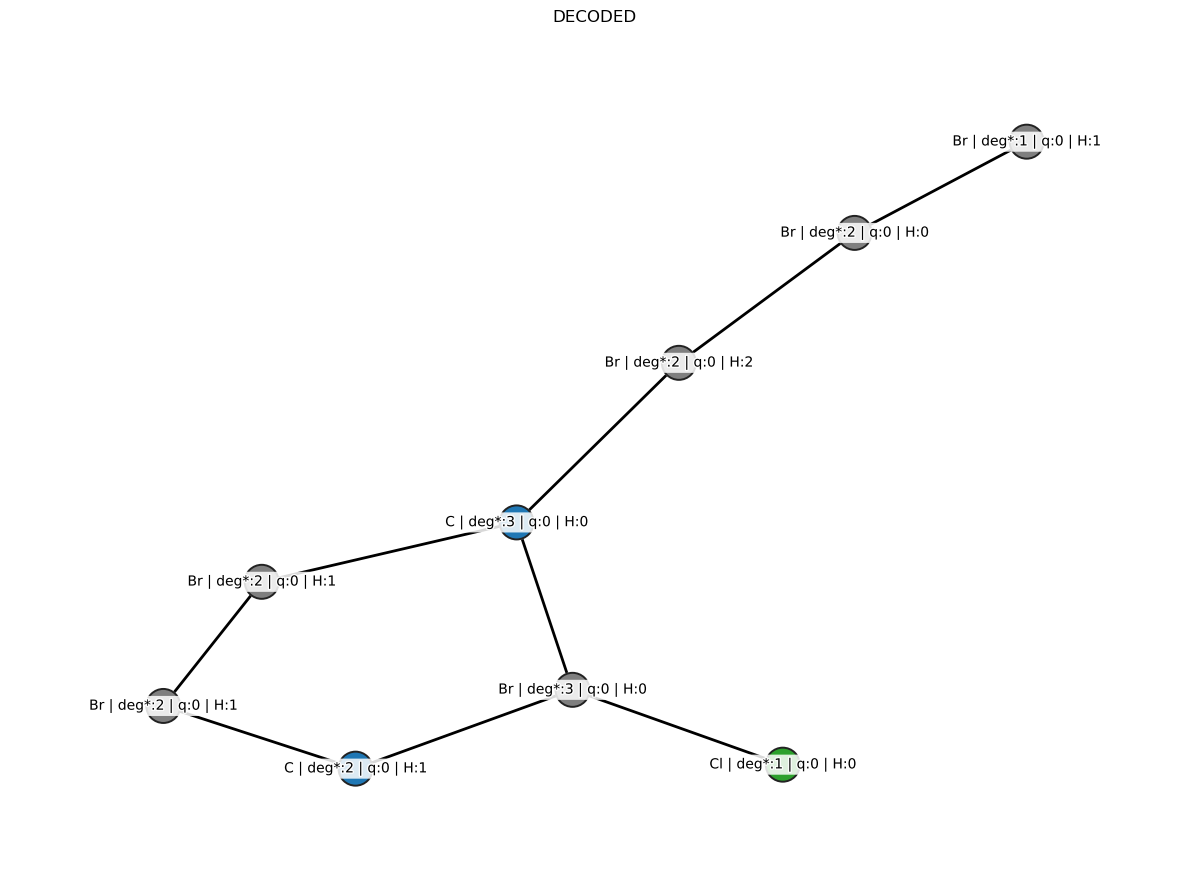

[16:16:47] Explicit valence for atom # 1 Br, 3, is greater than permitted
[16:16:47] Explicit valence for atom # 1 Br, 3, is greater than permitted


RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 306 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2023.03.3
	BOOST: 1_78


Num Atoms 9
Num Bonds 9
Accuracy: 1.0
File Name: /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_large_qm9/models/epoch16-val0.2740.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
Starting oracle decoding... for /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_large_qm9/models/epoch16-val0.2740.ckpt
Decoding a graph with 9 nodes and 9 edges.
No Graphs encoded ...!
Accuracy: 0.0
File Name: /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_base_qm9/models/epoch18-val0.2566.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
Starting oracle decoding... for /home/akaveh/Projects/kit/graph_hdc/_models/2_bah_lightning/BAH_base_qm9/models/epoch18-val0.2566.ckpt
Decoding a graph with 9 nodes and 9 edges.
No Graphs encoded ...!
Accuracy: 0.0
File Name: /home/akaveh/Projects/kit/g

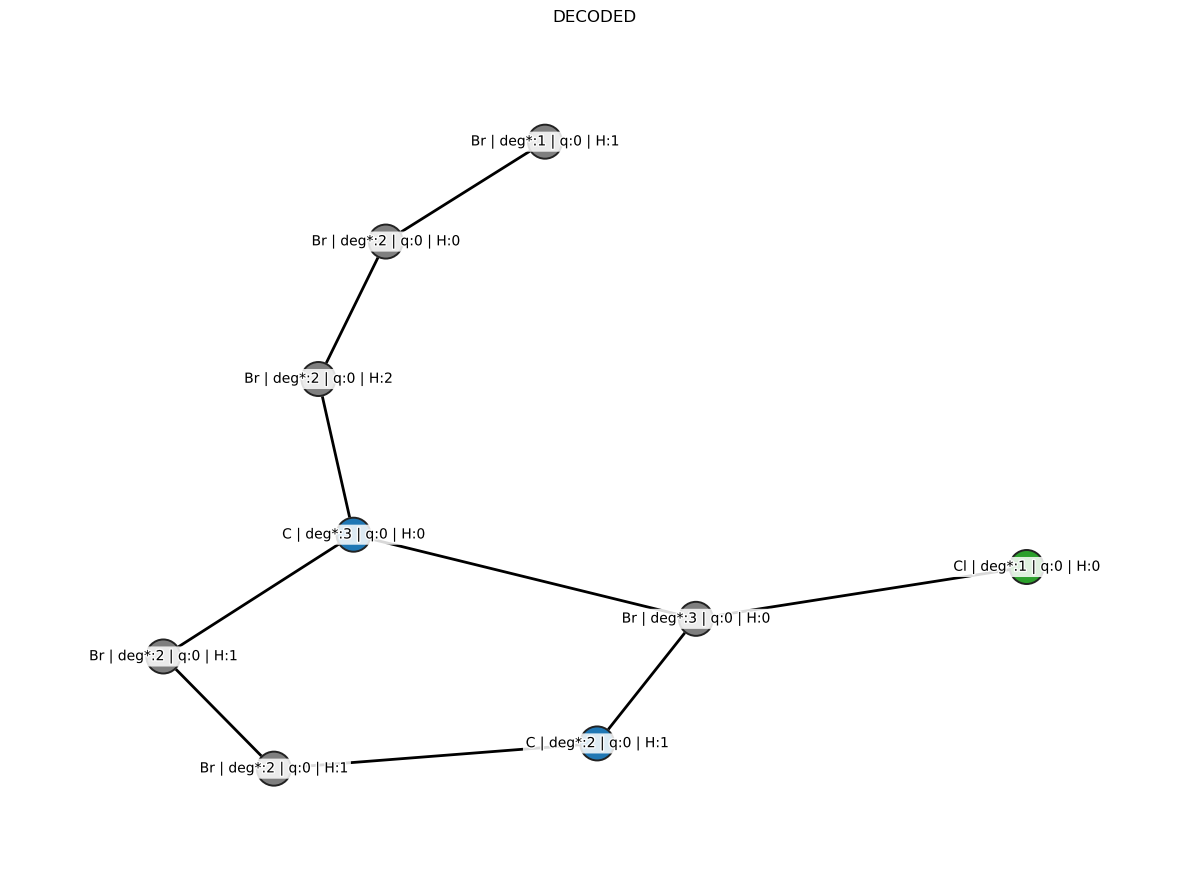

[16:16:50] Explicit valence for atom # 1 Br, 3, is greater than permitted
[16:16:50] Explicit valence for atom # 1 Br, 3, is greater than permitted


RuntimeError: Pre-condition Violation
	getExplicitValence() called without call to calcExplicitValence()
	Violation occurred on line 306 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_explicitValence > -1
	RDKIT: 2023.03.3
	BOOST: 1_78


Num Atoms 9
Num Bonds 9
Accuracy: 1.0
File Name: /home/akaveh/Projects/kit/graph_hdc/_models/1_mlp_lightning/MLP_medium_qm9/models/epoch06-val0.2831.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
[2025-09-16 16:16:50] Using Layer Normalization: True
Using Batch Normalization: False
Starting oracle decoding... for /home/akaveh/Projects/kit/graph_hdc/_models/1_mlp_lightning/MLP_medium_qm9/models/epoch06-val0.2831.ckpt
Decoding a graph with 9 nodes and 9 edges.
No Graphs encoded ...!
Accuracy: 0.0
File Name: /home/akaveh/Projects/kit/graph_hdc/_models/1_mlp_lightning/MLP_deep_qm9/models/epoch02-val0.3406.ckpt
Loading existing HyperNet from /home/akaveh/Projects/kit/graph_hdc/_models/hypernet_QM9SmilesHRR1600_HRR_dim1600_s42_depth3_ecb0.pt
[2025-09-16 16:16:50] Using Layer Normalization: True
Using Batch Normalization: False
Starting oracle decoding... for /home/akaveh/Projects/kit/graph_hdc/_models/1

In [1]:
from src.datasets.qm9_smiles_generation import QM9Smiles
from src.encoding.decoder import greedy_oracle_decoder_faster
from src.utils import visualisations
import matplotlib.pyplot as plt
import networkx as nx
import torch
from pytorch_lightning import seed_everything
from torch_geometric.loader import DataLoader
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import SupportedDataset
from src.encoding.graph_encoders import HyperNet, load_or_create_hypernet
from src.utils import registery
from src.utils.utils import GLOBAL_MODEL_PATH, find_files
from src.encoding.oracles import Oracle
from pprint import pprint
from src.utils.utils import DataTransformer
from torchhd import HRRTensor


# Real Oracle
def is_final_graph(G_small: nx.Graph, G_big: nx.Graph) -> bool:
    """NetworkX VF2: is `G_small` an induced, label-preserving subgraph of `G_big`?"""
    if G_small.number_of_nodes() == G_big.number_of_nodes() and G_small.number_of_edges() == G_big.number_of_edges():
        nm = lambda a, b: a["feat"] == b["feat"]
        GM = nx.algorithms.isomorphism.GraphMatcher(G_big, G_small, node_match=nm)
        return GM.subgraph_is_isomorphic()
    return False

start = 0
end = 1
batch_size = end - start
seed = 42
seed_everything(seed)
device = torch.device('cpu')


results: dict[str, str] = {}
# Iterate all the checkpoints
for ckpt_path in find_files(start_dir=GLOBAL_MODEL_PATH, prefixes=("epoch",), skip_substring="nvp"):
    print(f"File Name: {ckpt_path}")

    ## Determine model type
    model_type: registery.ModelType = "MLP"
    if "bah" in str(ckpt_path):
        model_type = "BAH"
    elif "gin-c" in str(ckpt_path):
        model_type = "GIN-C"
    elif "gin-f" in str(ckpt_path): # Case gin-f
        model_type = "GIN-F"

    split = "valid"
    ## Determine Dataset
    if "zinc" in str(ckpt_path):
        ds = SupportedDataset.ZINC_SMILES_HRR_7744
        dataset = ZincSmiles(split=split)
    else: # Case qm9
        ds = SupportedDataset.QM9_SMILES_HRR_1600
        dataset = QM9Smiles(split=split)

    ## Hyper net
    hypernet: HyperNet = (
        load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=ds.default_cfg).to(device=device)
    )
    assert not hypernet.use_edge_features()
    assert not hypernet.use_graph_features()

    ## Classifier and Oracle
    try:
        classifier = registery.retrieve_model(name=model_type).load_from_checkpoint(ckpt_path, map_location="cpu", strict=True).to(device).eval()
    except Exception as e:
        results[ckpt_path] = f"Error: {e}"
        continue
    oracle = Oracle(model=classifier, encoder=hypernet, model_type=model_type)

    ## Data loader
    dataset = dataset[start:end]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)



    y = []
    correct_decoded = []
    print(f"Starting oracle decoding... for {ckpt_path}")

    for i, batch in enumerate(dataloader):
        # Encode the whole graph in one HV
        encoded_data = hypernet.forward(batch)
        node_term = encoded_data["node_terms"]
        graph_term = encoded_data["graph_embedding"]

        graph_terms_hd = graph_term.as_subclass(HRRTensor)

        ground_truth_counters = {}
        datas = batch.to_data_list()
        for j, g in enumerate(range(batch_size)):
            print("================================================")
            full_graph_nx = DataTransformer.pyg_to_nx(data=datas[g])
            node_multiset = DataTransformer.get_node_counter_from_batch(batch=g, data=batch)
            # print(f"[{j}] Original Graph")
            # visualisations.draw_nx_with_atom_colorings(full_graph_nx, label="ORIGINAL")
            # plt.show()
            # mol_full, _ = DataTransformer.nx_to_mol(full_graph_nx)
            # display(mol_full)

            # print(f"Num Nodes {datas[g].num_nodes}")
            # print(f"Num Edges {int(datas[g].num_edges / 2)}")
            # print(f"Multiset Nodes {node_multiset.total()}")
            nx_GS: list[nx.Graph] = greedy_oracle_decoder_faster(
                node_multiset=node_multiset,
                oracle=oracle,
                full_g_h=graph_terms_hd[g],
                beam_size=8,
                oracle_threshold=0.5,
                strict=True,
                use_pair_feasibility=False,
                expand_on_n_anchors=4,
            )
            # print(len(nx_GS))
            # print(nx_GS)
            nx_GS = list(filter(None, nx_GS))
            if len(nx_GS) == 0:
                y.append(0)
                print("No Graphs encoded ...!")
                continue

            sub_g_ys = [0]
            for i, g in enumerate(nx_GS):
                is_final = is_final_graph(g, full_graph_nx)
                print("Is final graph: ", is_final)
                if is_final:
                    print(f"Graph Nr: {i}")
                    visualisations.draw_nx_with_atom_colorings(g, label="DECODED")
                    plt.show()
                    mol, _ = DataTransformer.nx_to_mol(g)
                    display(mol)
                    print(f"Num Atoms {mol.GetNumAtoms()}")
                    print(f"Num Bonds {mol.GetNumBonds()}")

                sub_g_ys.append(int(is_final))
            is_final_graph_ = int(sum(sub_g_ys) >= 1)
            y.append(is_final_graph_)
            if is_final_graph_:
                correct_decoded.append(j)
            sub_g_ys = []

    acc = sum(y) / len(y)
    results[ckpt_path.as_posix()] = f"Accuracy {acc} on {batch_size} of validation set."
    print(f"Accuracy: {acc}")

pprint(results)
